## Analysis xtal minimizations

Description: Brief analysis of results from minimizing xtal structures with two different force fields (Sage, Parsley) and three different minimization strategies. The three minimization strategies were:

1.) Minimize box paramters and position vectors together ("All-in-one")

2.) Minimize box parameters and positions vectors in alternating fashion

3.) First do 1.), then do 2.)

In [1]:
MAIN="/nfs/data_onsager/projects/xtalmd/xtalmd-scripts/examples/OFFBenchmark"
success_code_list = list()
with open(f"{MAIN}/success_xml.txt", "r") as fopen:
    for line in fopen:
        line = line.replace("\n", "")
        line = line.replace("CIF/", "")
        line = line.replace(".cif", "")
        if len(line) > 0:
            success_code_list.append(line)
            
success_xml = 0
failed_xml = 0
success_pdb = 0
failed_pdb = 0
with open(f"{MAIN}/success_xml.txt", "r") as fopen:
    success_xml = len(fopen.readlines())-1
with open(f"{MAIN}/failed_xml.txt", "r") as fopen:
    failed_xml = len(fopen.readlines())-1
with open(f"{MAIN}/success_pdb.txt", "r") as fopen:
    success_pdb = len(fopen.readlines())-1
with open(f"{MAIN}/failed_pdb.txt", "r") as fopen:
    failed_pdb = len(fopen.readlines())-1
    
print(f"Successful xml: {success_xml}")
print(f"Failed xml: {failed_xml}")
print(f"Successful pdb: {success_pdb}")
print(f"Failed pdb: {failed_pdb}")

Successful xml: 178
Failed xml: 114
Successful pdb: 232
Failed pdb: 60


From 293 CIF files, 232 xtal structures were successfully build and an RDKIT object was generated for molecule in the xtal structure. For 178 of these 232 xtal structures, sage ff parameters were obtained. Failing to obtain ff parameters were due to various reasons, for instance no ff parameter found, no hydrogen present, stereochemistry not clear. However these failures were not well documented at this point.

In [3]:
import os
import numpy as np
from openmm import app

def get_final_ene(path):
    if not os.path.exists(path):
        return None, None
    data=np.loadtxt(path, delimiter=',')
    if data.ndim == 1:
        final_ene = data[1]
        start_ene = data[1]
    else:
        final_ene = data[-1,1]
        start_ene = data[0,1]
    return final_ene, start_ene

def get_rmsd(pdb_path_1, pdb_path_2):
    if not os.path.exists(pdb_path_1):
        return None
    if not os.path.exists(pdb_path_2):
        return None
    pos1 = app.PDBFile(pdb_path_1).getPositions(asNumpy=True)
    pos2 = app.PDBFile(pdb_path_2).getPositions(asNumpy=True)
    topology    = app.PDBFile(pdb_path_1).getTopology()
    non_H_idxs  = list()
    for atom_idx, atom in enumerate(topology.atoms()):
        if atom.element.atomic_number != 1:
            non_H_idxs.append(atom_idx)
    
    diff = np.linalg.norm(
        pos1[non_H_idxs]-pos2[non_H_idxs],
        axis=1
    )
    rmsd = np.sqrt(
        np.mean(
            diff**2
        )
    )
    return rmsd    

def retrieve_data(ff_name, query_code_list):
    code_list = list()
    ene_list = list()
    rmsd_list = list()

    for code in query_code_list:
        ### ================================= ###
        ### Simultaneous minimization pos/box ###
        ### ================================= ###
        ene_min, ene_start = get_final_ene(
            f"{MAIN}/{ff_name}_min/{code}.csv"
        )
        rmsd_min = get_rmsd(
            f"{MAIN}/{ff_name}_xml/{code}.pdb",
            f"{MAIN}/{ff_name}_min/{code}.pdb"
        )

        ### ================================ ###
        ### Alternating minimization pos/box ###
        ### ================================ ###
        ene_min_alternating, _ = get_final_ene(
            f"{MAIN}/{ff_name}_min_alternating/{code}.csv"
        )
        rmsd_min_alternating = get_rmsd(
            f"{MAIN}/{ff_name}_xml/{code}.pdb",
            f"{MAIN}/{ff_name}_min_alternating/{code}.pdb",
        )

        ### ================================================ ###
        ### Subsequent simultaneous/alternating minimization ###
        ### ================================================ ###
        ene_min_combo, _ = get_final_ene(
            f"{MAIN}/{ff_name}_min_combo/{code}.csv"
        )
        rmsd_min_combo = get_rmsd(
            f"{MAIN}/{ff_name}_xml/{code}.pdb",
            f"{MAIN}/{ff_name}_min_combo/{code}.pdb",
        )    

        if any(
            [
                ene_min == None,
                ene_min_alternating == None,
                ene_min_combo == None,

            ]
        ):
            print(f"Could not find {ff_name} minimum energy for {code}")
            continue

        code_list.append(code)
        ene_list.append(
            [
                ene_min - ene_start, 
                ene_min_alternating - ene_start, 
                ene_min_combo - ene_start
            ]
        )
        rmsd_list.append(
            [
                rmsd_min,
                rmsd_min_alternating,
                rmsd_min_combo
            ]
        )
    return code_list, ene_list, rmsd_list

In [4]:
parsley_code_list, parsley_ene_list, parsley_rmsd_list = retrieve_data("parsley", success_code_list)
sage_code_list, sage_ene_list, sage_rmsd_list = retrieve_data("sage", success_code_list)

Could not find parsley minimum energy for 2104943
Could not find parsley minimum energy for 2204844
Could not find parsley minimum energy for 2220312
Could not find parsley minimum energy for 2236004
Could not find parsley minimum energy for 2243066
Could not find parsley minimum energy for 4116819
Could not find parsley minimum energy for 4339655
Could not find parsley minimum energy for 4501702
Could not find parsley minimum energy for 4513593
Could not find parsley minimum energy for 4515127
Could not find parsley minimum energy for 7100390
Could not find parsley minimum energy for 7214681
Could not find parsley minimum energy for 7219235
Could not find sage minimum energy for 2012958
Could not find sage minimum energy for 2104943
Could not find sage minimum energy for 2105702
Could not find sage minimum energy for 2217222
Could not find sage minimum energy for 2234037
Could not find sage minimum energy for 2235036
Could not find sage minimum energy for 4506226
Could not find sage m

In [59]:
print(f"{len(parsley_code_list)} succesful minimizations for Parsley.")
print(f"{len(sage_code_list)} succesful minimizations for Sage.")

165 succesful minimizations for Parsley.
168 succesful minimizations for Sage.


From the 178 xtal structures with ff parameters found, 165 xtal structures could be successfully minimized using Parsley and 168 were successfully minimized using Sage.

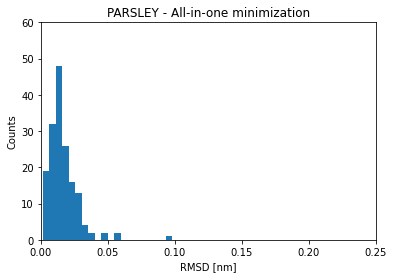

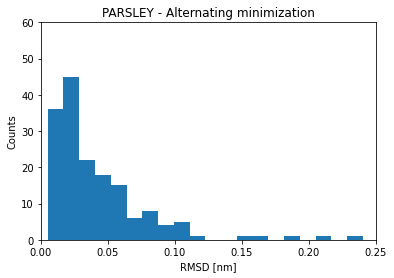

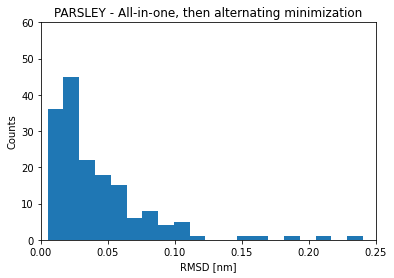

In [61]:
import matplotlib.pyplot as plt
parsley_ene_list = np.array(parsley_ene_list)
parsley_rmsd_list = np.array(parsley_rmsd_list)
plt.hist(
    parsley_rmsd_list[:,0],
    density=False,
    bins=20
)
plt.xlim(0,0.25)
plt.ylim(0,60)
plt.xlabel("RMSD [nm]")
plt.ylabel("Counts")
plt.title("PARSLEY - All-in-one minimization")
plt.show()

plt.hist(
    parsley_rmsd_list[:,1],
    density=False,
    bins=20
)
plt.xlim(0,0.25)
plt.ylim(0,60)
plt.xlabel("RMSD [nm]")
plt.ylabel("Counts")
plt.title("PARSLEY - Alternating minimization")
plt.show()

plt.hist(
    parsley_rmsd_list[:,2],
    density=False,
    bins=20
)
plt.xlim(0,0.25)
plt.ylim(0,60)
plt.xlabel("RMSD [nm]")
plt.ylabel("Counts")
plt.title("PARSLEY - All-in-one, then alternating minimization")
plt.show()

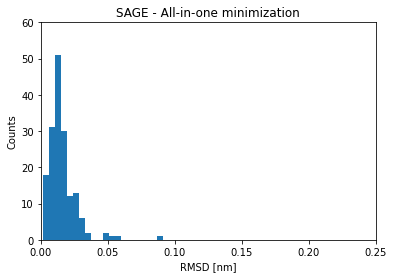

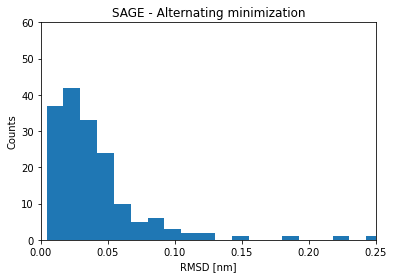

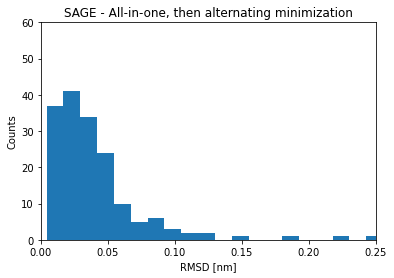

In [60]:
import matplotlib.pyplot as plt
sage_ene_list = np.array(sage_ene_list)
sage_rmsd_list = np.array(sage_rmsd_list)
plt.hist(
    sage_rmsd_list[:,0],
    density=False,
    bins=20
)
plt.xlim(0,0.25)
plt.ylim(0,60)
plt.xlabel("RMSD [nm]")
plt.ylabel("Counts")
plt.title("SAGE - All-in-one minimization")
plt.show()

plt.hist(
    sage_rmsd_list[:,1],
    density=False,
    bins=20
)
plt.xlim(0,0.25)
plt.ylim(0,60)
plt.xlabel("RMSD [nm]")
plt.ylabel("Counts")
plt.title("SAGE - Alternating minimization")
plt.show()

plt.hist(
    sage_rmsd_list[:,2],
    density=False,
    bins=20
)
plt.xlim(0,0.25)
plt.ylim(0,60)
plt.xlabel("RMSD [nm]")
plt.ylabel("Counts")
plt.title("SAGE - All-in-one, then alternating minimization")
plt.show()

Overall it seems that "All-in-one" minimization did not perform as well as the other two. In many cases (not documented how many) the BFGS minimizer stopped after only few iterations with the warning "Desired error not necessarily achieved due to precision loss.". This potentially solvable by carefully playing with the parameters of the algorithm.

The alternate routes involving the alternating minimization worked better here.